# Part 1 : None pre-trained data 
# Convolutional neural network : Classification

### Dhiaeddine YOUSFI & Wafa BOUZOUITA

In [1]:
import re
import numpy as np
import torch
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as lr_sch
import matplotlib.pyplot as plt
from time import clock

import random

# Deep Learning for NLP - lab exercise 2

In the first lab exercise we implemented a simple text classifiers that use a continuous bag-of-words representation (CBoW). Our goal is to predict if a sentence is a positive or negative review of a movie. We used a dataset constructed from IMDB. \\

Actually, The goal is to extend the first lab exercise by using a convolutional neural network instead of a bag-of-word model to predict if one reviews is positive or negative.\\ In this lab, we build a CNN module without using convolutional layers provided by Pytorch.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!


## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM=5000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [4]:
txt = postxt + negtxt
label = list(np.ones(LIM, int))+list(np.zeros(LIM, int))

In [5]:
from sklearn.model_selection import train_test_split

txt_train, txt_dev, label_train, label_dev = train_test_split(txt, label, test_size=0.1, random_state=26 ,stratify=label)

txt_train, txt_test, label_train, label_test = train_test_split(txt_train , label_train , test_size=0.1, random_state = 26 , stratify=label_train)

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [6]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [7]:
#Creating a dictionary where each word is associated to an index
word_index = {}
for sentence in txt_train:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1
            

In [8]:
Dict_index = Dict(word_index, unk=True)

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [9]:
loss = nn.BCEWithLogitsLoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [10]:
def train(model , epochs, X_train ,y_train , X_dev , y_dev , optimizer, lr):   
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    accuracy_train = []
    accuracy_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        
        #Adaptive lrlearning rate
        if((i+1)%2 == 0):
            for f in optimizer.param_groups:
                f['lr'] = f['lr']*0.75
                
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        #shuffle to reduce overfitting
        d = list(zip(X_train, y_train))
        np.random.shuffle(d)
        X_train, y_train = zip(*d)
        
        for sentence,label in zip(X_train , y_train):
            
            # initialize the parameters gradient to zero
            optimizer.zero_grad()
            
            #Creating the tensors for inputs
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            mean_loss+=loss_out.item()
            
            #Backward and updates
            loss_out.backward()
            optimizer.step()

            #Computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        accuracy_train.append(accuracy/len(X_train))
        
        print("EPOCH" , str(i+1) ,"On the training data : mean loss is :" , mean_loss/len(X_train) , "accuracy is: " ,accuracy/len(X_train))


        mean_loss = 0
        accuracy = 0
        
        #testing on dev data
        for sentence,label in zip(X_dev,y_dev):
            data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            
            mean_loss+=loss_out.item()
            
            
            #computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction < 0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On the dev data : mean loss is : " , mean_loss/len(X_dev) , " accuracy is : " ,accuracy/len(X_dev))
        print("----------------------------------------------------------------------------")
        mean_loss_dev.append(mean_loss/len(X_dev))
        accuracy_dev.append(accuracy/len(X_dev))
          
            
            
    #Plotting accuracy curves for dev and train data
    plt.figure()
    plt.plot(accuracy_train , label='Train')
    plt.plot(accuracy_dev, label="Dev")
    plt.title("Accuracy in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plotting loss curves for dev and train data
    plt.figure()    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    

In [11]:
#Calculating accuracy on test data
def test_accuracy(model,  X_test , y_test):
    
    accuracy = 0
    mean_loss = 0
        
    for sentence,label in zip(X_test,y_test):
        data = torch.LongTensor([Dict_index.str_to_id(word) for word in sentence])
        label = torch.Tensor([label])
             
        pred = model(data)
        loss_out = loss(pred , label)
        mean_loss += loss_out.item()
                        
            
        #computing accuracy
        if (pred >= 0.5 and label==1) or (pred<0.5 and label==0):
            accuracy += 1

            
    print("Accuracy on test set for this model is" , accuracy/len(X_test))
    return(accuracy/len(X_test))

# CNN Classifiers definition 

* Necessary functions to create the CNN classifier :

In [12]:
def reg(inputs,kernel_size):
    
    if(inputs.shape[0]<kernel_size):
        pad = torch.tensor([0 for i in range(kernel_size-inputs.shape[0])])
        inputs = torch.cat((inputs, pad), 0)
    return(inputs)  

def Conv(inputs,kernel_size, conv):
    concat_inp = []
    for i in range(inputs.shape[0]-kernel_size+1):
        Y = [inputs[j] for j in range(i, kernel_size+i)]
        concat = torch.cat(Y, 0)
        concat_inp.append(F.relu(conv(concat)) )
    return(concat_inp)

def Pooling(concat_list,pool_choice):
    
    h_ = torch.stack(concat_list)
    if pool_choice == "max":
        h_, _ = torch.max(h_, 0)
    if pool_choice == "mean":
        h_ = torch.mean(h_, 0)        
    return(h_)

def rec(proj,h,index):
    
    if index == len(proj)-1 :
        return(proj[index](h))
    
    z = torch.tanh(proj[index](h))
    index +=1
    return(rec(proj,z,index))

* A CNN classifier 

In [13]:
class CNN_1Lnet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, kernel_size, feature_size, pool_choice):
        super(CNN_1Lnet, self).__init__()
        
        #Parameters
        self.kernel_size = kernel_size
        self.feature_size = feature_size
        self.pool_choice  = pool_choice        

        #Embedding layer
        self.embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim=embedding_dim)
        
        #Convolution layer
        self.convs = nn.ModuleList([nn.Linear(embedding_dim*kernel_size[i],feature_size[0]) for i in range(len(kernel_size))])
        
        #output projection
        self.projs = nn.ModuleList([nn.Linear(feature_size[0]*len(kernel_size),feature_size[1])]+ 
                                   [nn.Linear(feature_size[i],feature_size[i+1])
                                    for i in range(1,len(feature_size)-1)])
        
        # Parameter initialization  
        for i in range(len(self.projs)):
            nn.init.xavier_uniform_(self.projs[i].weight.data)
            nn.init.zeros_(self.projs[i].bias.data)
            
        #dropout
        #self.dropout = nn.Dropout(p=0.5)  
        
    def forward(self, inputs):
        
        kernel_size = self.kernel_size
        pool_choice = self.pool_choice        
        #prepare the inputs
        inputs = [reg(inputs,kernel_size[i]) for i in range(len(kernel_size))]
        
        #Embending
        inp = [self.embeddings(inputs[i]) for i in range(len(kernel_size))]

        #Conv
        concat_inp = [Conv(inp[i],kernel_size[i], self.convs[i]) for i in range(len(kernel_size))]
        
        #Pooling
        h = [Pooling(concat_inp[i],pool_choice) for i in range(len(kernel_size))]
        
        #Concatenate the two output of convolution layer
        res = torch.cat(h,0)
        
        output = rec(self.projs,res,0)

        return output

## Simple CNN without hidden layer NN and with conv layer  : 

### kernel size = 2

In [14]:
emb  = 10
feat = [5,1]
size = [2]
lr = 0.1

#### Pooling : max   &   Opt = SGD

EPOCH 1 On the training data : mean loss is : 0.6886985242989397 accuracy is:  0.5337037037037037
EPOCH 1 On the dev data : mean loss is :  0.6573771810345351  accuracy is :  0.576
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.6143543407151455 accuracy is:  0.6224691358024691
EPOCH 2 On the dev data : mean loss is :  0.5868028833791613  accuracy is :  0.651
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.5061394837552381 accuracy is:  0.7251851851851852
EPOCH 3 On the dev data : mean loss is :  0.48877122145704927  accuracy is :  0.736
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4260402814601216 accuracy is:  0.7903703703703704
EPOCH 4 On the dev data : mean loss is :  0.4744242763794027  accuracy is :  0.747
--------------------------------------------

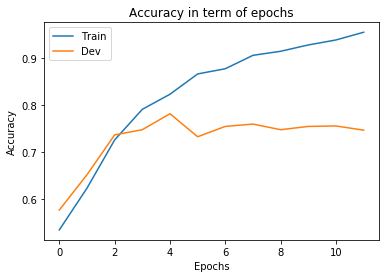

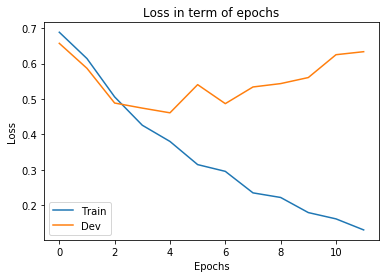

In [16]:
model_1 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "max")
optimizer_SGD = torch.optim.SGD(params=model_1.parameters(), lr=lr, weight_decay=1e-3)
train(model_1 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD, lr)

In [17]:
test_accuracy(model_1,  txt_test , label_test)

Accuracy on test set for this model is 0.7344444444444445


0.7344444444444445

#### Pooling : max   &   Opt = ADAM

EPOCH 1 On the training data : mean loss is : 0.6611101602332919 accuracy is:  0.5680246913580247
EPOCH 1 On the dev data : mean loss is :  0.6297810533419251  accuracy is :  0.581
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5542174691539028 accuracy is:  0.6790123456790124
EPOCH 2 On the dev data : mean loss is :  0.567679635738954  accuracy is :  0.662
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4925771077864704 accuracy is:  0.7353086419753087
EPOCH 3 On the dev data : mean loss is :  0.536152092478238  accuracy is :  0.699
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.44598823257091963 accuracy is:  0.7720987654320988
EPOCH 4 On the dev data : mean loss is :  0.5223805353554198  accuracy is :  0.715
----------------------------------------------

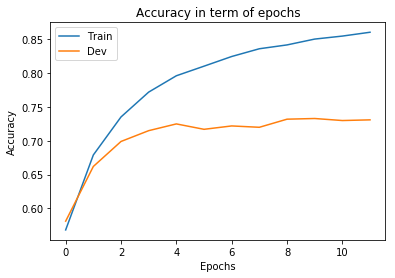

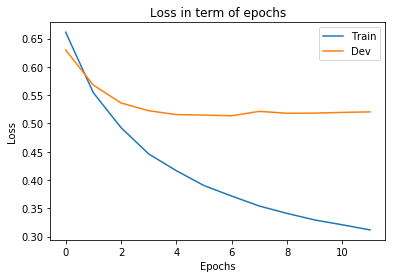

In [25]:
model_2 = CNN_1Lnet(len(Dict__index), emb, size, feat, pool_choice = "max")
optimizer_ADAM = torch.optim.Adam(params=model_2.parameters())
train(model_2 , 12, txt_train ,label_train, txt_dev, label_dev, optimizer_ADAM, lr)

In [26]:
test_accuracy(model_2,  txt_test , label_test)

Accuracy on test set for this model is 0.7244444444444444


0.7244444444444444

####  on a choisi OPT = SGD en raison du temps de calcul !!!!!!!!!!

#### Pooling : mean   &   Opt = SGD

In [27]:
emb  = 10
feat = [5,1]
size = [2] # change
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6754318645677564 accuracy is:  0.5360493827160494
EPOCH 1 On the dev data : mean loss is :  0.6157563790022396  accuracy is :  0.549
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5729561894060918 accuracy is:  0.6558024691358024
EPOCH 2 On the dev data : mean loss is :  0.5327530361934332  accuracy is :  0.732
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4869998701600758 accuracy is:  0.748641975308642
EPOCH 3 On the dev data : mean loss is :  0.4899004507690115  accuracy is :  0.741
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4091169238104274 accuracy is:  0.7932098765432098
EPOCH 4 On the dev data : mean loss is :  0.5249047829670198  accuracy is :  0.744
----------------------------------------------

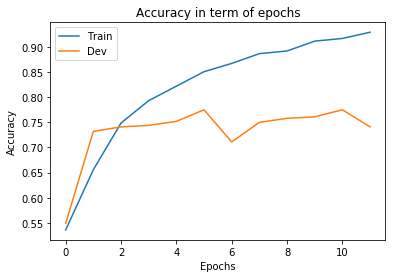

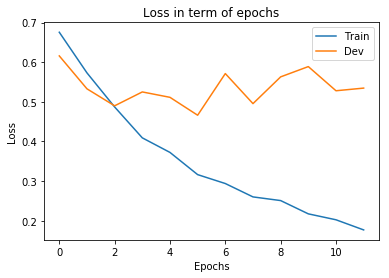

In [32]:
model_3 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_3.parameters(), lr=lr, weight_decay=1e-3)
train(model_3, 12, txt_train, label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [33]:
test_accuracy(model_3,  txt_test , label_test)

Accuracy on test set for this model is 0.74


0.74

###  Kernel Size = 3

#### mean & opt = SGD

In [30]:
emb  = 10
feat = [5,1]
size = [3]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6629172178985333 accuracy is:  0.5617283950617284
EPOCH 1 On the dev data : mean loss is :  0.5973627957249992  accuracy is :  0.645
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5413804127661004 accuracy is:  0.691604938271605
EPOCH 2 On the dev data : mean loss is :  0.5145684958191149  accuracy is :  0.723
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.46880011360626966 accuracy is:  0.7508641975308642
EPOCH 3 On the dev data : mean loss is :  0.5328336317839285  accuracy is :  0.703
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4067957250044494 accuracy is:  0.7951851851851852
EPOCH 4 On the dev data : mean loss is :  0.47845475996494097  accuracy is :  0.728
--------------------------------------------

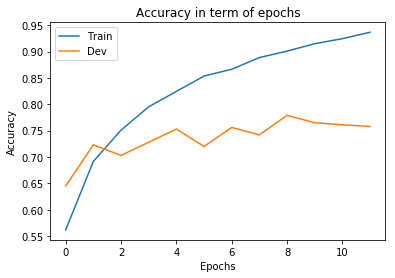

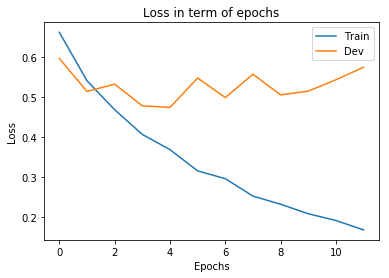

In [31]:
loss = nn.BCEWithLogitsLoss()
model_4 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_4.parameters(), lr=lr, weight_decay=1e-3)
train(model_4 , 12, txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [34]:
test_accuracy(model_4,  txt_test , label_test)

Accuracy on test set for this model is 0.7477777777777778


0.7477777777777778

#### max & opt = SGD

In [52]:
emb  = 10
feat = [5,1]
size = [3]
lr = 0.1

model_5 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_5.parameters(), lr=lr, weight_decay=1e-3)

EPOCH 1 :
On training : Mean Loss : 0.6708817135431318 Accuracy : 0.5545679012345679
On Dev  :Mean Loss : 0.6584379528136924 Accuracy : 0.554

EPOCH 2 :
On training : Mean Loss : 0.5623491368811246 Accuracy : 0.6753086419753086
On Dev  :Mean Loss : 0.5266075307758947 Accuracy : 0.7

EPOCH 3 :
On training : Mean Loss : 0.4713747077998531 Accuracy : 0.7509876543209877
On Dev  :Mean Loss : 0.5130172648854727 Accuracy : 0.711

EPOCH 4 :
On training : Mean Loss : 0.4147399590597738 Accuracy : 0.7961728395061728
On Dev  :Mean Loss : 0.47526939715018846 Accuracy : 0.748

EPOCH 5 :
On training : Mean Loss : 0.38568161167284803 Accuracy : 0.8140740740740741
On Dev  :Mean Loss : 0.4770485921805272 Accuracy : 0.738

EPOCH 6 :
On training : Mean Loss : 0.3554628880301715 Accuracy : 0.8374074074074074
On Dev  :Mean Loss : 0.4863000076680984 Accuracy : 0.743

EPOCH 7 :
On training : Mean Loss : 0.34396763197098423 Accuracy : 0.8462962962962963
On Dev  :Mean Loss : 0.498612433727199 Accuracy : 0.72



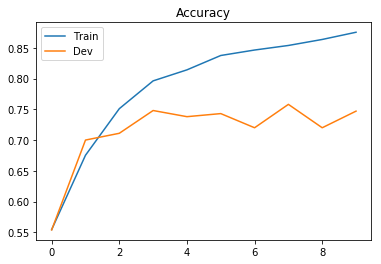

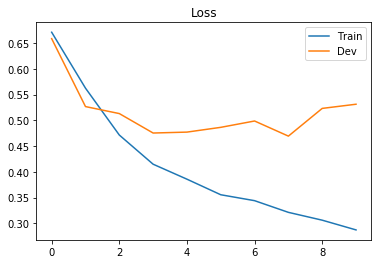

<Figure size 432x288 with 0 Axes>

In [53]:
loss = nn.BCEWithLogitsLoss()
train(model_5 , 12, txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [54]:
test_accuracy(model_5,  txt_test , label_test)

Accuracy on test set for this model is 0.7344444444444445


0.7344444444444445

## CNN with 2 conv layers  : 

### kernel Sizes = [2,3] & pool = max

In [40]:
emb  = 10
feat = [5,1]
size = [2,3]
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.683626909209444 accuracy is:  0.54
EPOCH 1 On the dev data : mean loss is :  0.6835502510073129  accuracy is :  0.608
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5839401547453285 accuracy is:  0.6334567901234568
EPOCH 2 On the dev data : mean loss is :  0.5662180890175514  accuracy is :  0.632
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.49832800772898567 accuracy is:  0.7232098765432099
EPOCH 3 On the dev data : mean loss is :  0.48153636521931914  accuracy is :  0.727
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4197618982896367 accuracy is:  0.7906172839506173
EPOCH 4 On the dev data : mean loss is :  0.48121544753425405  accuracy is :  0.709
---------------------------------------------------------

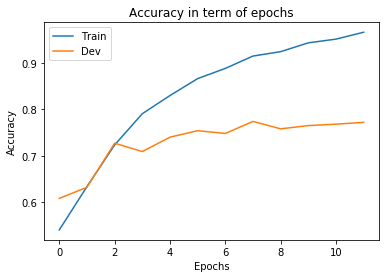

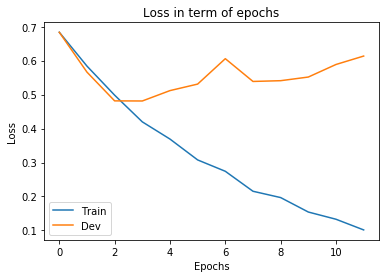

In [36]:
loss = nn.BCEWithLogitsLoss()
model_6 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "max")
optimizer_SGD = torch.optim.SGD(params=model_6.parameters(), lr=lr, weight_decay=1e-3)
train(model_6 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [37]:
test_accuracy(model_6,  txt_test , label_test)

Accuracy on test set for this model is 0.7566666666666667


0.7566666666666667

### kernel Sizes = [2,3] & pool = mean

EPOCH 1 On the training data : mean loss is : 0.6545128369907113 accuracy is:  0.567283950617284
EPOCH 1 On the dev data : mean loss is :  0.5973456833012933  accuracy is :  0.593
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5347338638110974 accuracy is:  0.6853086419753086
EPOCH 2 On the dev data : mean loss is :  0.5159299295367996  accuracy is :  0.702
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.46393089476811533 accuracy is:  0.7503703703703704
EPOCH 3 On the dev data : mean loss is :  0.5012558691525714  accuracy is :  0.699
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3933605783926218 accuracy is:  0.802716049382716
EPOCH 4 On the dev data : mean loss is :  0.5273572943539043  accuracy is :  0.718
----------------------------------------------

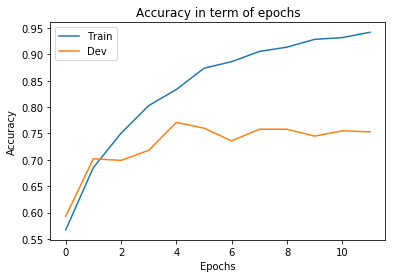

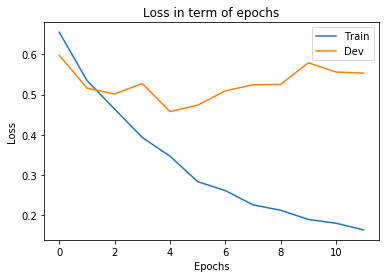

In [42]:
loss = nn.BCEWithLogitsLoss()
model_7 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_7.parameters(), lr=lr, weight_decay=1e-3)
train(model_7 , 12, txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [43]:
test_accuracy(model_7,  txt_test , label_test)

Accuracy on test set for this model is 0.7644444444444445


0.7644444444444445

### kernel Sizes = [1,2] & pool = mean

In [63]:
emb  = 10
feat = [5,1]
size = [1,2] # change
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6444895979085719 accuracy is:  0.5862962962962963
EPOCH 1 On the dev data : mean loss is :  0.5859489832697437  accuracy is :  0.629
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5356437099068122 accuracy is:  0.6979012345679012
EPOCH 2 On the dev data : mean loss is :  0.5206670389505743  accuracy is :  0.696
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4627505500719921 accuracy is:  0.7546913580246913
EPOCH 3 On the dev data : mean loss is :  0.5111068065969496  accuracy is :  0.678
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3987892295501554 accuracy is:  0.8003703703703704
EPOCH 4 On the dev data : mean loss is :  0.4937699935675938  accuracy is :  0.725
---------------------------------------------

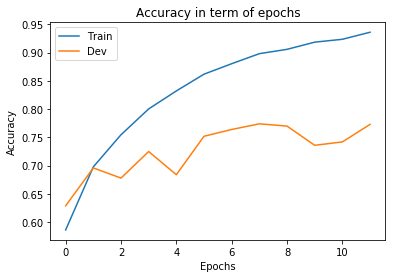

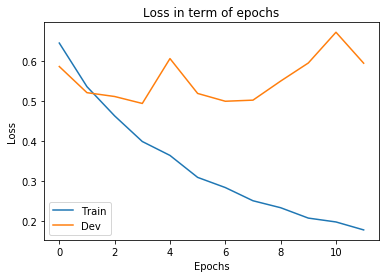

In [64]:
loss = nn.BCEWithLogitsLoss()
model_11 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_11.parameters(), lr=lr, weight_decay=1e-3)
train(model_11, 12, txt_train, label_train, txt_dev, label_dev, optimizer_SGD, lr)

In [65]:
test_accuracy(model_11,  txt_test , label_test)

Accuracy on test set for this model is 0.7566666666666667


0.7566666666666667

## CNN with 2 conv layers  : 

### kernel Sizes = [1,2,3] & pool = mean

In [44]:
emb  = 10
feat = [5,1]
size = [1,2,3] # change
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6476590547597404 accuracy is:  0.5808641975308642
EPOCH 1 On the dev data : mean loss is :  0.5703167041357374  accuracy is :  0.737
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5185382586122624 accuracy is:  0.7140740740740741
EPOCH 2 On the dev data : mean loss is :  0.5166487641712977  accuracy is :  0.739
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4500596543625917 accuracy is:  0.7782716049382716
EPOCH 3 On the dev data : mean loss is :  0.4595800863906809  accuracy is :  0.764
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.389209575677411 accuracy is:  0.8149382716049383
EPOCH 4 On the dev data : mean loss is :  0.45180003380602507  accuracy is :  0.772
---------------------------------------------

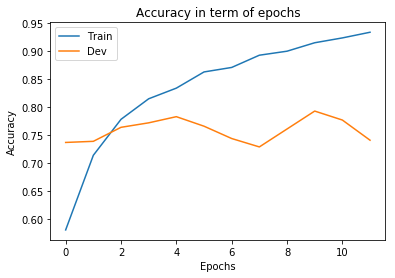

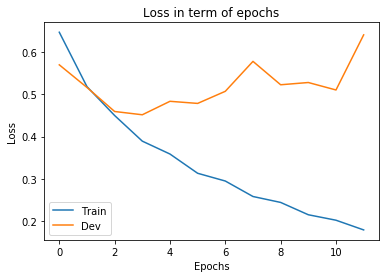

In [46]:
loss = nn.BCEWithLogitsLoss()
model_8 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_8.parameters(), lr=lr, weight_decay=1e-3)
train(model_8 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [47]:
test_accuracy(model_8,  txt_test , label_test)

Accuracy on test set for this model is 0.7288888888888889


0.7288888888888889

## CNN with 2 NN layers  and 1 conv layer  : 

In [48]:
emb  = 10
feat = [5,3,2,1]
size = [2,3] # change
lr = 0.1

EPOCH 1 On the training data : mean loss is : 0.6955342029642175 accuracy is:  0.509753086419753
EPOCH 1 On the dev data : mean loss is :  0.6740967317521572  accuracy is :  0.5
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.611751620468718 accuracy is:  0.6475308641975308
EPOCH 2 On the dev data : mean loss is :  0.5539130105376243  accuracy is :  0.707
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.5124367007171666 accuracy is:  0.7364197530864197
EPOCH 3 On the dev data : mean loss is :  0.6552105854600668  accuracy is :  0.664
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.4314163743752848 accuracy is:  0.7912345679012346
EPOCH 4 On the dev data : mean loss is :  0.525748778924346  accuracy is :  0.707
--------------------------------------------------

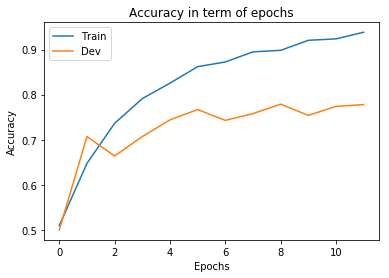

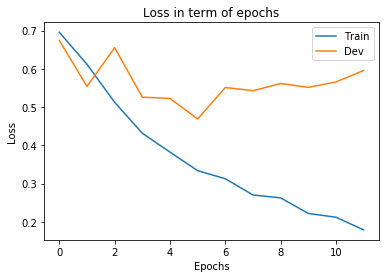

In [49]:
loss = nn.BCEWithLogitsLoss()
model_9 = CNN_1Lnet(len(Dict_index), emb, size, feat, pool_choice = "mean")
optimizer_SGD = torch.optim.SGD(params=model_9.parameters(), lr=lr, weight_decay=1e-3)
train(model_9 , 12,txt_train ,label_train, txt_dev, label_dev, optimizer_SGD , lr)

In [51]:
test_accuracy(model_9,  txt_test , label_test)

Accuracy on test set for this model is 0.7522222222222222


0.7522222222222222

## We'll comment on the resulats in the report ..